In [1]:
# We are using a dataset for stress detection using sleep patterns avaiable on kaggle provided by SayoPillows
# Using this dataset we are going to detect stress measures using KNN, NB and DT and compare their results

In [2]:
# First import some basic important libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn import metrics

#if anything is not intalled just use (!pip install <library name>)

In [3]:
df = pd.read_csv('/Users/rudranichangal/Documents/study/SaYoPillow.csv')
df.head()

#read the dataset and save it in df 
#head() is used to show first 5 records


,sr,rr,t,lm,bo,rem,sr.1,hr,sl
0,93.80,25.680,91.840,16.600,89.840,99.60,1.840,74.20,3
1,91.64,25.104,91.552,15.880,89.552,98.88,1.552,72.76,3
2,60.00,20.000,96.000,10.000,95.000,85.00,7.000,60.00,1
3,85.76,23.536,90.768,13.920,88.768,96.92,0.768,68.84,3
4,48.12,17.248,97.872,6.496,96.248,72.48,8.248,53.12,0


In [4]:
#check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sr      630 non-null    float64
 1   rr      630 non-null    float64
 2   t       630 non-null    float64
 3   lm      630 non-null    float64
 4   bo      630 non-null    float64
 5   rem     630 non-null    float64
 6   sr.1    630 non-null    float64
 7   hr      630 non-null    float64
 8   sl      630 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 44.4 KB


In [5]:
# check for null value
df.isna().values.sum()

0

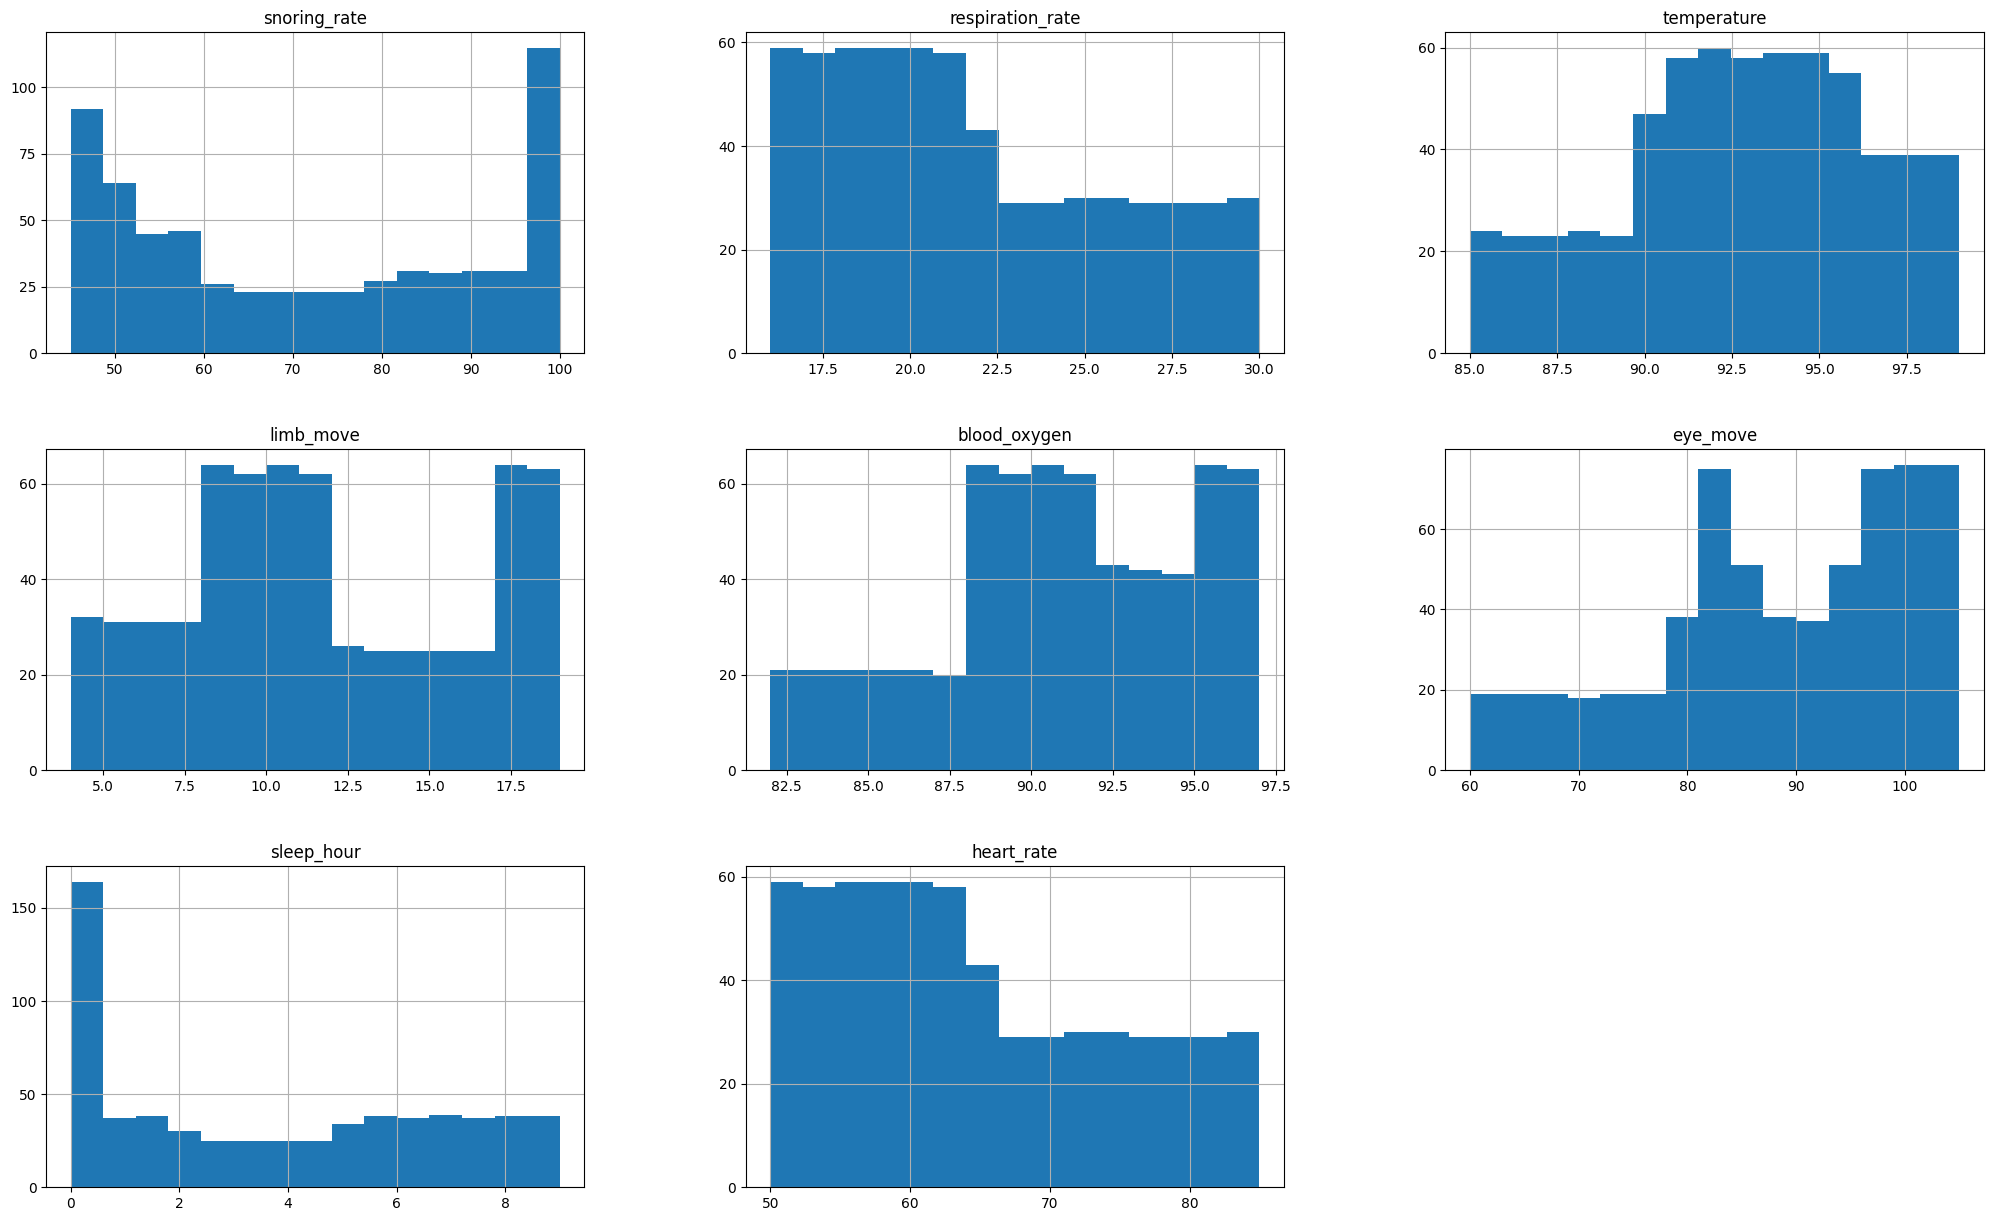

In [6]:
#mention coloumn names, make a copy of data to make changes and histogram of all coloumns
#Check the distribution of data from each column.
df.columns = ['snoring_rate', 'respiration_rate', 'temperature', 'limb_move', 'blood_oxygen', 'eye_move', 'sleep_hour', 'heart_rate', 'stress_level']
data = df.copy()
data.drop('stress_level', axis = 1, inplace = True)
data.hist(bins=15, figsize=(25,15))
plt.rcParams['font.size'] = 18
plt.show()

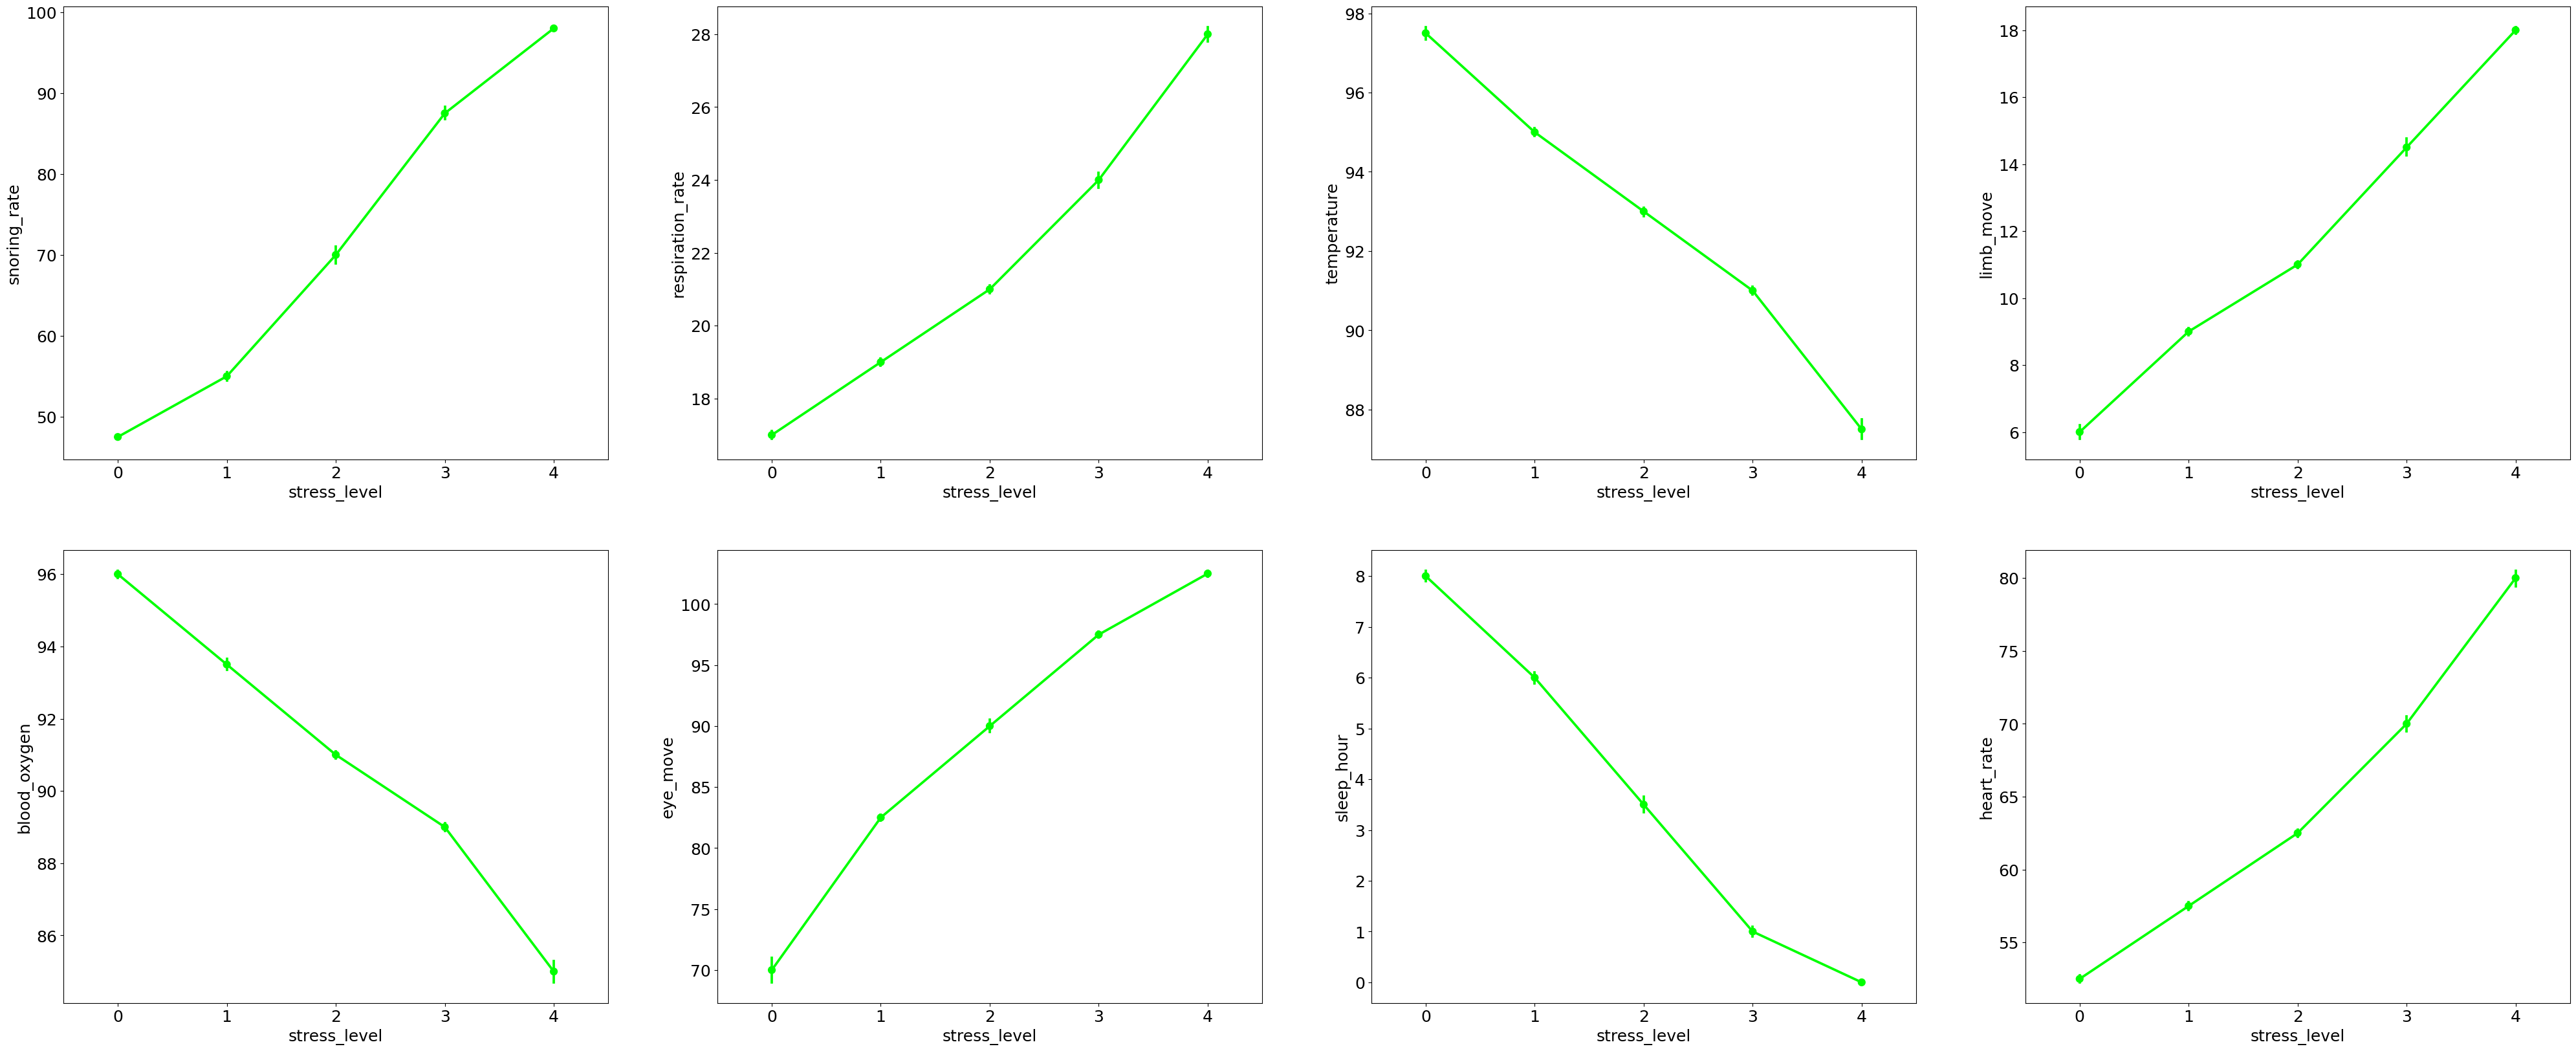

In [7]:
fig = plt.figure(figsize=(50, 20))
rows = 2
columns = 4
for i in range(len(df.columns[:-1])):
  fig.add_subplot(rows, columns, (i+1))
  img = sns.pointplot(x='stress_level',y=df.columns[i],data=df,color='lime')

plt.show()

#####

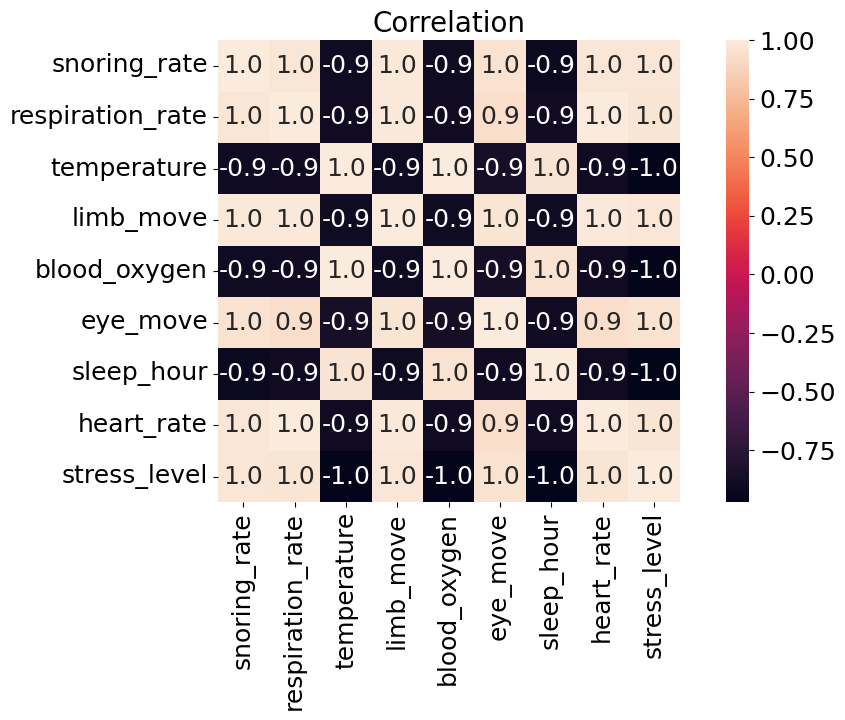

In [8]:
plt.figure(figsize = (12,6))
sns.heatmap(df.corr(), annot=True, square=True,fmt='.1f' )
plt.title('Correlation', fontsize = 20)
plt.show()

###### Check the correlation between features. it can be seen that all features have a very strong correlation, 
where if the correlation value is equal to 1, 
then the correlation is positive. If the correlation value is equal to -1, then the correlation is negative.

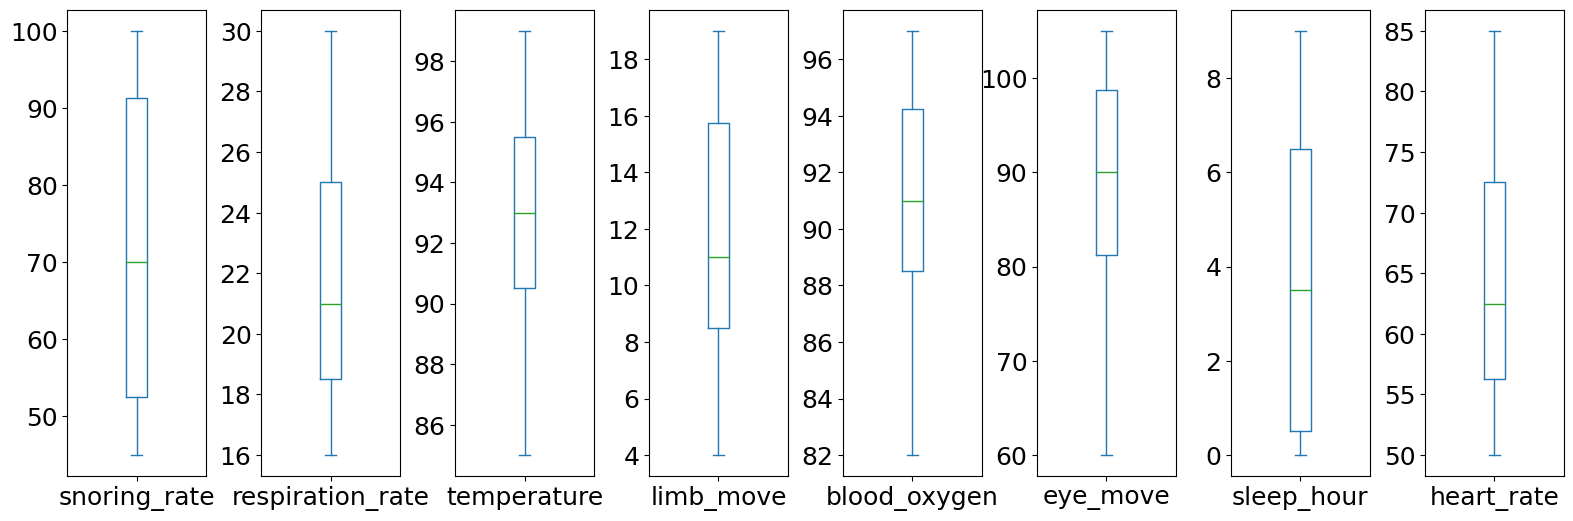

In [9]:
data.plot(kind='box', subplots=True, layout=(2,14),figsize=(14,14))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=2, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

Check whether there are outlier data in each column in the data. It can be seen that there are no outliers in the data.





## Data Preparation

In [10]:
#seperating target value for features
x = df.copy();
x.drop('stress_level', axis = 1, inplace = True)
y = df['stress_level']

In [11]:
#normalizing by setting the features in the range of (0,1)
x = minmax_scale(x)

In [12]:
x.view()

array([[0.88727273, 0.69142857, 0.48857143, ..., 0.88      , 0.20444444,
        0.69142857],
       [0.848     , 0.65028571, 0.468     , ..., 0.864     , 0.17244444,
        0.65028571],
       [0.27272727, 0.28571429, 0.78571429, ..., 0.55555556, 0.77777778,
        0.28571429],
       ...,
       [0.95461818, 0.82171429, 0.13428571, ..., 0.93066667, 0.        ,
        0.82171429],
       [0.248     , 0.26628571, 0.76628571, ..., 0.54044444, 0.74755556,
        0.26628571],
       [0.52581818, 0.38514286, 0.59942857, ..., 0.71022222, 0.45422222,
        0.38514286]])

In [14]:
#seperating training data and test data in 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2,random_state =123)

In [15]:
# Showing data after pre processed
data_preprocessed = pd.DataFrame(x, columns = ['snoring_rate', 'respiration_rate', 'temperature', 'limb_move', 'blood_oxygen', 'eye_move', 'sleep_hour', 'heart_rate'])
data_preprocessed['stress_level'] = y
data_preprocessed.head()

,snoring_rate,respiration_rate,temperature,limb_move,blood_oxygen,eye_move,sleep_hour,heart_rate,stress_level
0,0.887273,0.691429,0.488571,0.840000,0.522667,0.880000,0.204444,0.691429,3
1,0.848000,0.650286,0.468000,0.792000,0.503467,0.864000,0.172444,0.650286,3
2,0.272727,0.285714,0.785714,0.400000,0.866667,0.555556,0.777778,0.285714,1
3,0.741091,0.538286,0.412000,0.661333,0.451200,0.820444,0.085333,0.538286,3
4,0.056727,0.089143,0.919429,0.166400,0.949867,0.277333,0.916444,0.089143,0


### Modeling

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [17]:
# Doing Cross Validation and find hyperparameter
from pandas.core.common import random_state
k = [5,10,15]
max_depth = [20, 40, 60]
for i in range(3):
    models = []
    models.append(('KNN', KNeighborsClassifier(n_neighbors=k[i])))
    models.append(('NB', GaussianNB()))
    models.append(('DT', DecisionTreeClassifier(max_depth=max_depth[i], random_state=101)))
    results = []
    names = []
    print("K:",k[i], "and max_depth:", max_depth[i])
    for name, model in models:
        kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(name)
        print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    print("")

K: 5 and max_depth: 20
KNN: 1.000000 (0.000000)
NB: 1.000000 (0.000000)
DT: 0.980198 (0.014002)

K: 10 and max_depth: 40
KNN: 1.000000 (0.000000)
NB: 1.000000 (0.000000)
DT: 0.980198 (0.014002)

K: 15 and max_depth: 60
KNN: 1.000000 (0.000000)
NB: 1.000000 (0.000000)
DT: 0.980198 (0.014002)



###### Hyperparameter search for KNN and DT models. In KNN testing of the hyperparameter values of K 5, 10, and 15 produced the same accuracy values. Therefore the chosen value of K is 5.

##### In DT, the hyperparameter test with max_depth values of 20, 40, and 60 produces the same accuracy value. Therefore, the max_depth value is chosen to be 40.

In [18]:
# Create K-NN Model
model_KNN = KNeighborsClassifier(n_neighbors=5)
model_KNN.fit(X_train, y_train)
predict_KNN = model_KNN.predict(X_test)

In [19]:
# Create NB Model
model_NB = GaussianNB()
model_NB.fit(X_train, y_train)
predict_NB = model_NB.predict(X_test)


In [20]:
# Create DT Model
model_DT = DecisionTreeClassifier(max_depth=40,random_state=101)
model_DT.fit(X_train, y_train)
predict_DT = model_DT.predict(X_test)

### Evaluation

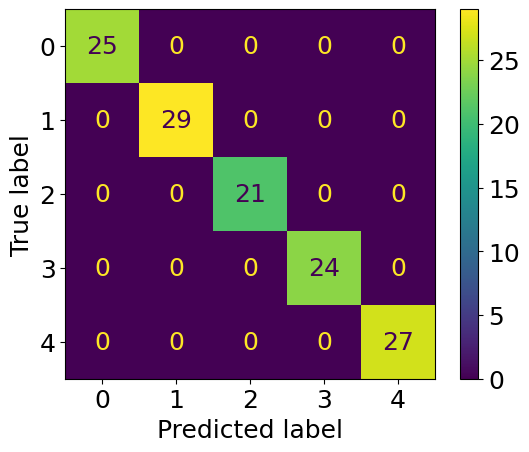

In [21]:
#knn
confusion_matrix = metrics.confusion_matrix(y_test, predict_KNN)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1,2,3,4])

cm_display.plot()
plt.show()

In [22]:
print(classification_report(y_test, predict_KNN))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        29
           2       1.00      1.00      1.00        21
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        27

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126



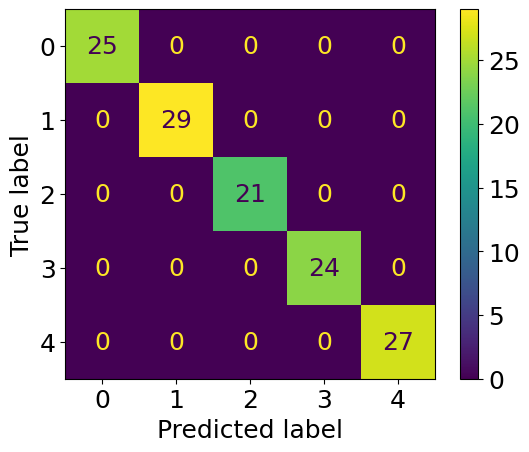

In [23]:
#nb
confusion_matrix = metrics.confusion_matrix(y_test, predict_NB)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1,2,3,4])

cm_display.plot()
plt.show()


In [24]:
print(classification_report(y_test, predict_NB))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        29
           2       1.00      1.00      1.00        21
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        27

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126



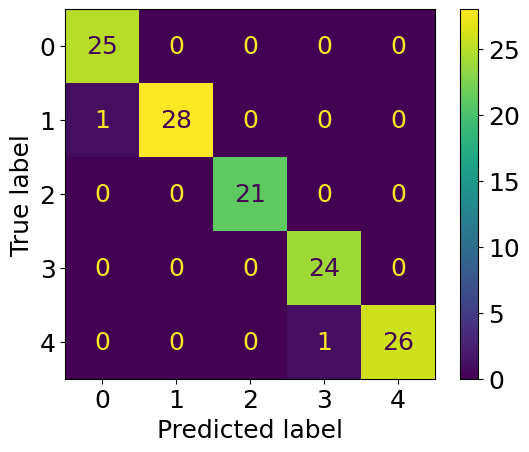

In [25]:
#dt
confusion_matrix = metrics.confusion_matrix(y_test, predict_DT)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1,2,3,4])

cm_display.plot()
plt.show()

In [27]:
print(classification_report(y_test, predict_DT))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        25
           1       1.00      0.97      0.98        29
           2       1.00      1.00      1.00        21
           3       0.96      1.00      0.98        24
           4       1.00      0.96      0.98        27

    accuracy                           0.98       126
   macro avg       0.98      0.99      0.98       126
weighted avg       0.98      0.98      0.98       126



### Conclusion

For all the models that have been made it is very good because it gets high accuracy. Where the K-NN and Naive Bayes models get an accuracy of 100%, while the Decision Tree model gets an accuracy of 98%. To improve the model that has been made, when searching for hyperparameters for the range, multiply it again so that you get the optimal hyperparameter.